In [2]:
!pip install -Uqq fastbook
import fastbook
try:
  fastbook.setup_book()
except Exception as e:
  print(e)

     |████████████████████████████████| 727kB 13.1MB/s 
     |████████████████████████████████| 194kB 29.8MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.1MB 29.0MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 40kB 7.3MB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 2.6MB 55.5MB/s 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:



mount failed: invalid oauth code


In [3]:
from fastbook import *

DATA

In [4]:
path = untar_data(URLs.IMAGENETTE_160)
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_12140.JPEG')

In [5]:
from glob import glob # what is glob, i know it was mentioned someplace before.
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_12140.JPEG')

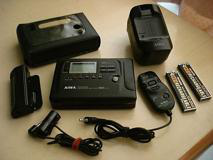

In [6]:
im = Image.open(files[0])
im

In [7]:
im_t = tensor(im)
im_t.shape

torch.Size([160, 213, 3])

In [8]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n02979186','n03028079','n03445777','n03888257','n02102040','n01440764','n03417042','n03000684','n03394916','n03425413']

In [9]:
v2i = lbls.val2idx(); v2i
# labels to index

{'n01440764': 5,
 'n02102040': 4,
 'n02979186': 0,
 'n03000684': 7,
 'n03028079': 1,
 'n03394916': 8,
 'n03417042': 6,
 'n03425413': 9,
 'n03445777': 2,
 'n03888257': 3}

DATASET

a dataset class should have a `__getitem__` and a `len`

In [10]:
class Dataset:
  def __init__(self, fns):
    self.fns = fns
  
  def __len__(self):
    return len(self.fns)
    # returns lenght of dataset
  
  def __getitem__(self,i):
    im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
    y = v2i[self.fns[i].parent.name]
    return tensor(im).float()/255, tensor(y)
    # returns the tensor and the label

In [11]:
train_filt = L(o.parent.parent.name =='train' for o in files)
train, valid = files[train_filt], files[~train_filt]
# filtering into training and validation set
len(train), len(valid)

(9469, 3925)

In [12]:
# sending training and validation set into dataset seperately
train_ds, valid_ds = Dataset(train), Dataset(valid)
x, y = valid_ds[25]

x.shape, y

(torch.Size([64, 64, 3]), tensor(0))

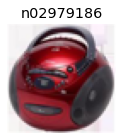

In [13]:
show_image(x, title=lbls[y])

In [14]:
# creating mini batch
def collate(idxs, ds):
  xb, yb = zip(*[ds[i] for i in idxs])
  return torch.stack(xb), torch.stack(yb) 
  # howis tacking creating mini batch

In [15]:
x, y = collate([1,2], train_ds)
x.shape, y
# using collate to stack of two

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

DATALOADER

we add two more things here, an optional shuffle for training set and a proess poolexecutor to do our preprocessing in parallel. Since loading an image is difficult we need to use dataloader class.

In [16]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds) 

In [39]:
n_workers = min(16, defaults.cpus)

# 16 parallel processse
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb, yb = first(train_dl)
xb.shape, yb.shape, len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

for normalization statistics,we will need image statistics. Generally its fine to calculate these on asingle training mini batch, since precision isn't needed

In [40]:
stats = [xb.mean((0,1,2)), xb.std((0,1,2))]
stats

[tensor([0.4643, 0.4538, 0.4150]), tensor([0.2654, 0.2640, 0.2853])]

Our Normalize class just needs to store these stats and apply them. 

In [44]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

In [45]:
# lets test the normalize plan
norm= Normalize(stats)
def tfm_x(x): 
  return norm(x).permute((0,3,1,2))

In [46]:
t = tfm_x(x)
t.mean((0,2,3)), t.std((0,2,3))

(tensor([0.7917, 0.8227, 0.9222]), tensor([1.0606, 1.0480, 0.9652]))

tfm_x isn't just applying normalize but is also permuting the axis order from NCHW.

MODULE AND PARAMETER

To create a model we will need Module. TO create Module we will need Parameter. 

PArameter claas doesn't add any functionality for us other than calling requires_grad_ for us.

In [47]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

The implementation here is a bit awkward: we have to define the special `__new__` Python method and use the internal PyTorch method `_make_subclass` because, as at the time of writing, PyTorch doesn't otherwise work correctly with this kind of subclassing or provide an officially supported API to do this. This may have been fixed by the time you read this, so look on the book's website to see if there are updated details.

Our `Parameter` now behaves just like a tensor, as we wanted:

In [48]:
Parameter(tensor(3.))

tensor(3., requires_grad=True)

In [50]:
class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        # thanks to this it returns all parameters
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        # we are using setattr for setting an attribute ?
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

CONVLAYER (MODULE)

In [51]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        # this we are not implementting , refer to previous chapter for details
        if self.act: x = F.relu(x)
        return x

In [52]:
l = ConvLayer(3,4)
len(l.parameters())

2

In [53]:
# we can now call it 
# this results in forward being called , how?
xbt = tfm_x(xb)
r = l(xbt)
r.shape

(128, 4, 64, 64)

LINEAR (MODULE)

In [54]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x): return x@self.w.t() + self.b

In [55]:
# testing if it works

l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

(3, 2)

TESTING MODULE

to see if we include multiple parameters if they are all correctly registered

In [56]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)

In [58]:
t =T()
#since we have a conv layer and linear layer answer should be 4
len(t.parameters())

4

In [59]:
# calling cuda should invoke GPU
t.cuda()
t.l.w.device

device(type='cuda', index=0)

SIMPLE CNN

In [61]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)
        # register_modules is defined above

    def forward(self, x):
        # call each layer in turn
        for l in self.layers: x = l(x)
        return x

ADAPTIVEPOOL(MODULE)

pooling to 1x1 output and output and flattens it

In [62]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

In [63]:
# enough to create a CNN
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

Lets see if our parameters are being registered correctly

In [64]:
m =simple_cnn()
len(m.parameters())

10

Now we can try adding a hook. Note that we have only left room for one hookin Module, you could make it a list, or use something like Pipeline to run a as a single funtion

In [65]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.47633856534957886 0.8025630712509155
0.3370107114315033 0.6208107471466064
0.3477499485015869 0.5658355951309204
0.2985159754753113 0.5070981979370117


(128, 10)

LOSS


In [66]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()
# negative log liklihood

In [67]:
# log together with softmax
def log_softmax(x):
  return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

sm = log_softmax(r)
sm[0][0]


tensor(-3.7929, grad_fn=<AliasBackward>)

In [68]:
loss = nll(sm, yb)
loss

tensor(2.4004, grad_fn=<AliasBackward>)

Note that the formula, simplyfying:

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1))).log()`:

In [69]:
def log_softmax(x):
  return x - x.exp().sum(-1, keepdim=True).log()

sm = log_softmax(r)
sm[0][0]

tensor(-3.7929, grad_fn=<AliasBackward>)

Then, there is a more stable way to compute the log of the sum of exponentials, called the [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where $a$ is the maximum of $x_{j}$.


Here's the same thing in code:

In [70]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(False)

In [71]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(2.5639, grad_fn=<AliasBackward>)

In [72]:
# using it on log_softmax
def log_softmax(x):
  return x - x.logsumexp(-1,keepdim=True)

In [73]:
sm = log_softmax(r)
sm[0][0]

tensor(-3.7929, grad_fn=<AliasBackward>)

In [74]:
def cross_entropy(preds, yb):
  return nll(log_softmax(preds), yb).mean()

LEARNER

combining all those together to create a Learner

In [93]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

Life is easier with a Learner

In [97]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [98]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')
    
    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

This is the largest class we've created in the book, but each method is quite small, so by looking at each in turn you should be able to follow what's going on.

The main method we'll be calling is `fit`. This loops with:

```python
for self.epoch in range(n_epochs)
```

and at each epoch calls `self.one_epoch` for each of `train=True` and then `train=False`. Then `self.one_epoch` calls `self.one_batch` for each batch in `dls.train` or `dls.valid`, as appropriate (after wrapping the `DataLoader` in `fastprogress.progress_bar`. Finally, `self.one_batch` follows the usual set of steps to fit one mini-batch that we've seen throughout this book.

Before and after each step, `Learner` calls `self`, which calls `__call__` (which is standard Python functionality). `__call__` uses `getattr(cb,name)` on each callback in `self.cbs`, which is a Python built-in function that returns the attribute (a method, in this case) with the requested name. So, for instance, `self('before_fit')` will call `cb.before_fit()` for each callback where that method is defined.

As you can see, `Learner` is really just using our standard training loop, except that it's also calling callbacks at appropriate times. So let's define some callbacks!

CALLBACKS

In `Learner.__init__` we have:

```python
for cb in cbs: cb.learner = self
```

In other words, every callback knows what learner it is used in. This is critical, since otherwise a callback can't get information from the learner, or change things in the learner. Because getting information from the learner is so common, we make that easier by defining `Callback` as a subclass of `GetAttr`, with a default attribute of `learner`:

In [99]:
 class Callback(GetAttr):
   _default='learner'

`GetAttr` is a fastai class that implements Python's standard `__getattr__` and `__dir__` methods for you, such that any time you try to access an attribute that doesn't exist, it passes the request along to whatever you have defined as `_default`.

In [100]:
# if we want to move all model parameters to the GPU 
# automatically at the start of fit.
# we have to setuplearnerCb inherit from Callback ,
# we can remove .learner and just call self.model.cuda

class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In `SetupLearnerCB` we also move each mini-batch to the GPU, by calling `to_device(self.batch)` (we could also have used the longer `to_device(self.learner.batch)`. Note however that in the line `self.learner.batch = tfm_x(xb),yb` we can't remove `.learner`, because here we're *setting* the attribute, not getting it.

Before we try our `Learner` out, let's create a callback to track and print progress. Otherwise we won't really know if it's working properly:

In [101]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [102]:
cbs = [SetupLearnerCB(), TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1170808609013623 0.23920160523814551


0 False 2.011334345143312 0.2871337579617834


SCHEDULING LEARNING RATE

In [104]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

This shows how we're using `CancelFitException`, which is itself an empty class, only used to signify the type of exception. You can see in `Learner` that this exception is caught. (You should add and test `CancelBatchException`, `CancelEpochException`, etc. yourself.) Let's try it out, by adding it to our list of callbacks:

In [105]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.9359699248864715 0.12060407646002745


0 False 3.4512400477707006 0.10292993630573248


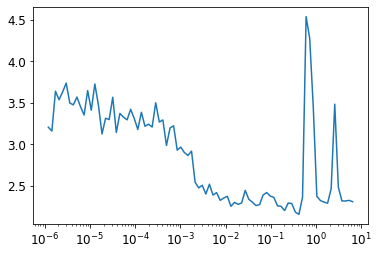

In [106]:
plt.plot(lrfind.lrs[:-2], lrfind.losses[:-2])
plt.xscale('log')

In [107]:
class OneCycle(Callback):
  def __init__(self, base_lr):
    self.base_lr = base_lr
  def before_fit(self):
    self.lrs = []
  
  def before_batch(self):
    if not self.model.training:
      return
    n = len(self.dls.train)
    bn = self.epoch*n + self.num
    mn = self.n_epochs*n
    pct = bn/mn
    pct_start, div_start = 0.25, 10
    if pct< pct_start:
      pct /= pct_start
      lr = (1-pct)* self.base_lr/div_start + pct*self.base_lr
    else :
      pct = (pct-pct_start)/(1-pct_start)
      lr = (1-pct)* self.base_lr
    self.opt.lr = lr
    self.lrs.append(lr)

In [108]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [109]:
learn.fit(8)

0 True 2.17555600842222 0.19558559509979934


0 False 2.1928652468152867 0.21121019108280253


1 True 2.0426603835542294 0.26729327278487697


1 False 1.9625289858678343 0.30547770700636945


2 True 1.9317790289365298 0.32305417678741155


2 False 1.8796591361464967 0.3518471337579618


3 True 1.8060455499524766 0.37300665328968213


3 False 1.813915953423567 0.3543949044585987


4 True 1.7236814910827436 0.40658992501848135


4 False 1.745881518710191 0.38598726114649684


5 True 1.645308972865403 0.44027880452001267


5 False 1.6657247710987262 0.43337579617834393


6 True 1.581191853845443 0.46277326011194425


6 False 1.6112450238853504 0.45171974522292996


7 True 1.5384956832822896 0.4852677157038758


7 False 1.5961681429140127 0.4575796178343949


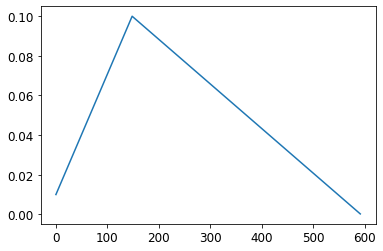

In [110]:
plt.plot(onecyc.lrs)

CONCLUSION

We have explored the key concepts of the fastai library are implemented by re-implementing them in this chapter. Since it's mostly full of code, you should definitely try to experiment with it by looking at the corresponding notebook on the book's website. Now that you know how it's built, as a next step be sure to check out the intermediate and advanced tutorials in the fastai documentation to learn how to customize every bit of the library.